# Retrieving Pseudo-MPC Observations for JUICE from txt file

## Objectives
In this example show how to retrieve pseudo-MPC data from Bill Gray's website. We will use the Tudat Horizons interface to compare observation ouput and load the standard SPICE kernels.

## Key API References

## Import statements

In [255]:
from tudatpy.data.mpc import BatchMPC
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.data.horizons import HorizonsQuery


from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.numerical_simulation import estimation, estimation_setup
from tudatpy.kernel.numerical_simulation.estimation_setup import observation


# Load spice kernels
spice.load_standard_kernels()

## Workflow
Unlike what already done in the example [Retrieving_mpc_observation_data (ADD LINK)](), we cannout initialize the BatchMPC object yet, since astroquery...is not linked to Bill Gray's html page. We therefore need to 

1) parse B.G.'s html page containing the data, and retrieve the information needed (obs. time, angular observables, station codes, obs. band, etc...).
2) feed this information into a table that is similar to the one created (in the other example) using the `.get_observations()` method.
3) convert the newly created table into a `Batch.MPC` object using `.from_astropy()` .

### 1) Parsing the html page

In [256]:
#FOR JUICE
from astroquery.mpc import MPC
import requests
import re
from tudatpy import constants

from astropy.time import Time
from astropy.table import Table, Column
from bs4 import BeautifulSoup
import pandas as pd

#MPC.query_object = requests.get("https://www.minorplanetcenter.net/tmp2/JUICE.txt", "-28")

try:
    with open('/Users/luigigisolfi/Desktop/Untitled.txt', 'r') as file:
        file_contents = file.readlines()
except FileNotFoundError:
    print("File not found. Please check the path.")

# Initialize lists to hold the extracted data
numbers = []
epochs = []
RAs = []
DECs = []
bands = []
observatories = []

for i, line in enumerate(file_contents):
    print(line)

    if line[14] == 's':
        continue
    number = i+1
    #print(f'observation n. {number}')
    
    # Extract the observation string (without the band and observatory)
    observation_string = line[15:]
    print(observation_string)
    
    year = observation_string[0:4]  # Year (e.g., 2023)
    if year.startswith('K'):
        continue
    month = observation_string[5:7]  # Month (e.g., 04)
    print(month)
    date_part, frac_day = observation_string[8:17].split('.')
    print(date_part,frac_day)
    print(f'Day:{date_part}, Fraction of Day:{frac_day}')
    numbers.append(number)

    # Calculate the time in hours, minutes, seconds
    hours = float("0." + frac_day) * 24
    minutes = (hours % 1) * 60
    seconds = (minutes % 1) * 60
    seconds_int = int(seconds)
    microseconds = int((seconds - seconds_int) * 1_000_000)
    
    if round(seconds) == 60: 
        minutes = minutes + 1
        seconds = 0
    #print(f'Hours:{hours}, Minutes:{minutes}, Seconds:{seconds}')
    # Convert to Julian date
    time_string = f"{date_part} {int(hours):02}:{int(minutes):02}:{seconds:02}"
    epoch = f'{year}-{month}-{date_part} {int(hours):02}:{int(minutes):02}:{seconds_int:02}.{microseconds:06}'
    #print(f'Epoch:{epoch}')
    dt = datetime.strptime(epoch, "%Y-%m-%d %H:%M:%S.%f")
    dt_jd = Time(dt).jd
    epochs.append(dt_jd)

    ra_dec_str = observation_string[17:43]  # RA and DEC part
    print(f'ra & dec str:{ra_dec_str}')
    ra_part = ra_dec_str[:12].strip()  # Right Ascension
    print(f'ra part: {ra_part}')
    dec_part = ra_dec_str[12:].strip()  # Declination (considering no space if negative)
    print(f'dec part:{dec_part}')

    #Right Ascension
    parts_RA = ra_part.split()
    hours_RA = float(parts_RA[0])
    minutes_RA = float(parts_RA[1]) if len(parts_RA) > 1 else 0
    seconds_RA = float(parts_RA[2]) if len(parts_RA) > 2 else 0
    deg_ra = 15*hours_RA + 0.25*minutes_RA + seconds_RA/240

    #Declination
    parts_DEC = dec_part.split()
    degrees_DEC = float(parts_DEC[0])
    minutes_DEC = float(parts_DEC[1]) if len(parts_DEC) > 1 else 0
    seconds_DEC = float(parts_DEC[2]) if len(parts_DEC) > 2 else 0
    if parts_DEC[0][0] == '-':
        print(f'yesss, {parts_DEC[0]}')
        deg_dec = - (abs(degrees_DEC) + minutes_DEC / 60 + seconds_DEC / 3600)
    else:
        deg_dec = (abs(degrees_DEC) + minutes_DEC/ 60 + seconds_DEC/ 3600)
    #print(f'deg_ra {deg_ra}')
    #print(f'deg_dec {deg_dec}')
    # Extract Band
    band = observation_string[-10:-8]

    bands.append(band)

    print(band)
    # Extract the observatory code
    observatory = line[-4:-1]
    #print(observatory)
    observatories.append(observatory)
    RAs.append(deg_ra) #this is in degrees
    DECs.append(deg_dec) #this is in degrees

JUICE         C2024 07 05.58600122 15 06.895-11 03 21.35   ~781n 20.98wXNEOCPF51

2024 07 05.58600122 15 06.895-11 03 21.35   ~781n 20.98wXNEOCPF51

07
05 586001
Day:05, Fraction of Day:586001
ra & dec str:22 15 06.895-11 03 21.35  
ra part: 22 15 06.895
dec part:-11 03 21.35
yesss, -11
XN
JUICE         C2024 07 05.59312722 15 07.115-11 03 18.58   ~781n 21.03wXNEOCPF51

2024 07 05.59312722 15 07.115-11 03 18.58   ~781n 21.03wXNEOCPF51

07
05 593127
Day:05, Fraction of Day:593127
ra & dec str:22 15 07.115-11 03 18.58  
ra part: 22 15 07.115
dec part:-11 03 18.58
yesss, -11
XN
JUICE         C2024 07 05.60026522 15 07.343-11 03 15.84   ~781n 20.94wXNEOCPF51

2024 07 05.60026522 15 07.343-11 03 15.84   ~781n 20.94wXNEOCPF51

07
05 600265
Day:05, Fraction of Day:600265
ra & dec str:22 15 07.343-11 03 15.84  
ra part: 22 15 07.343
dec part:-11 03 15.84
yesss, -11
XN
JUICE        KC2024 07 06.32265422 15 59.810-10 59 10.21   ~781n 20.6 GVNEOCPH21

2024 07 06.32265422 15 59.810-10 59 10.21   ~

### 2) Feeding the table
Note that RA and Dec are given in **degrees** (they could be given in radians, but we leave it this way to be consistent with the previous JUICE example)

In [257]:
# Create the table
table = Table()

# Add columns to the table
table.add_column(Column(name='number', data= np.transpose(['-28']*len(numbers))))
table.add_column(Column(name='designation', data= np.transpose(['JUICE']*len(numbers))))
table.add_column(Column(name='discovery', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note1', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='note2', data= np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='epoch', data=epochs))
table.add_column(Column(name='RA', data=RAs, unit='deg'))  # RA in degrees
table.add_column(Column(name='DEC', data=DECs, unit='deg'))  # DEC in degrees
table.add_column(Column(name='mag', data=np.transpose(['NaN']*len(numbers))))
table.add_column(Column(name='band', data=bands))
table.add_column(Column(name='observatory', data=observatories))

# Display the table
print(table)

number designation discovery note1 ...         DEC         mag band observatory
                                   ...         deg                             
------ ----------- --------- ----- ... ------------------- --- ---- -----------
   -28       JUICE       NaN   NaN ... -11.055930555555557 NaN   XN         F51
   -28       JUICE       NaN   NaN ... -11.055161111111111 NaN   XN         F51
   -28       JUICE       NaN   NaN ... -11.054400000000001 NaN   XN         F51
   -28       JUICE       NaN   NaN ... -10.986169444444444 NaN   VN         H21
   -28       JUICE       NaN   NaN ... -10.985580555555554 NaN   VN         H21
   -28       JUICE       NaN   NaN ... -10.959388888888888 NaN   VN         T14
   -28       JUICE       NaN   NaN ... -10.959302777777777 NaN   VN         T14
   -28       JUICE       NaN   NaN ... -10.959211111111111 NaN   VN         T14
   -28       JUICE       NaN   NaN ... -10.913844444444445 NaN   VN         Q64
   ...         ...       ...   ... ...  

### Creating the BatchMPC object
Note that batch1.table.query always gives the result in **radians**.  

In [258]:
batch1 = BatchMPC()
batch1.from_astropy(table, in_degrees = True)
batch1.summary()

batch1.filter(
    epoch_start=datetime(2024, 7, 1),
    observatories_exclude=["C51", "C57", "C59"],
)

print(batch1.table)
#rint(batch1.observatories_table(only_in_batch=True, only_space_telescopes=False, include_positions=False))


   Batch Summary:
1. Batch includes 1 minor planets:
   ['-28']
2. Batch includes 91 observations, including 0 observations from space telescopes
3. The observations range from 2024-07-05 14:03:50.486391 to 2024-08-17 07:33:53.280006
   In seconds TDB since J2000: 773460299.6704056 to 777152102.462934
   In Julian Days: 2460497.086001 to 2460539.8152
4. The batch contains observations from 15 observatories, including 0 space telescopes

   number designation discovery note1 note2         epoch        RA       DEC  \
0     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825538 -0.192962   
1     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825554 -0.192949   
2     -28       JUICE       NaN   NaN   NaN  2.460497e+06  5.825570 -0.192936   
3     -28       JUICE       NaN   NaN   NaN  2.460498e+06  5.829386 -0.191745   
4     -28       JUICE       NaN   NaN   NaN  2.460498e+06  5.829402 -0.191735   
..    ...         ...       ...   ...   ...           ...       ...     

### Retrieve Observation Collection

In [259]:
# List the bodies for our environment
"""
A system of bodies must be created to keep observatories' positions consistent with Earth's shape model and to allow the attachment of these observatories to Earth. For the purposes of this example, we keep it as simple as possible. See the [Estimation with MPC](https://docs.tudat.space/en/latest/_src_getting_started/_src_examples/notebooks/estimation/estimation_with_mpc.html) for a more complete setup and explanation appropriate for estimation. For our bodies, we only use Earth and the Sun. We set our origin to `"SSB"`, the solar system barycenter. We use the default body settings from the `SPICE` kernel to initialise the planet and use it to create a system of bodies. This system of bodies is used in the `to_tudat()` method.
"""

bodies_to_create = [
    "Sun", 
    "Earth", 
    "Moon", 
    "Jupiter", 
    "Saturn", 
    "Mars", 
    "Mercury", 
    "Neptune", 
    "Uranus", 
    "Venus"
]

# Create default body settings
global_frame_origin = "SSB"
global_frame_orientation = "J2000"

body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)


# Create system of bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

# Retrieve JUICE' body name from BatchMPC and set its centre to enable its propapgation
bodies_to_propagate = batch1.MPC_objects
central_bodies = [global_frame_origin]

# Now that our batch is ready, we can transform it to a Tudat `ObservationCollection` object using the `to_tudat()` method.
#
# The `.to_tudat()` does the following for us:
#
# 1. Creates an empty body for each minor planet with their MPC code as a name.
# 2. Adds this body to the system of bodies inputted to the method.
# 3. Retrieves the global position of the terrestrial observatories in the batch and adds these stations to the Tudat environment.
# 4. Creates link definitions between each unique terrestrial observatory/ minor planet combination in the batch.
# 5. (Optionally) creates a link definition between each space telescope / minor planet combination in the batch. This requires an addional input.
# 6. Creates a `SingleObservationSet` object for each unique link that includes all observations for that link.
# 7. Returns an `ObservationCollection` object.
# 7. Returns an `ObservationCollection` object.
#
# If our batch includes space telescopes like WISE and TESS we must either link their Tudat name or exclude them. For now we exclude them by setting `included_satellites` to `None`. The additional features section shows an example of how to link satellites to the `to_tudat()` method. The '.to_tudat()' method does not alter the batch object itself.

observation_collection = batch1.to_tudat(bodies, included_satellites=None, apply_star_catalog_debias = False)

In [260]:
# We can now retrieve the links from the ObservationCollection we got from `.to_tudat()` and we can create settings for these links. This is where link biases would be set, for now we just keep the settings default.

observation_settings_list = list()

link_list = list(
    observation_collection.get_link_definitions_for_observables(
        observable_type=observation.angular_position_type
    )
)

for link in link_list:
    # add optional bias settings
    observation_settings_list.append(
        observation.angular_position(link, bias_settings=None)
    )

# Retrieve MPC observation times, RA and DEC
batch_times = batch1.table.epochJ2000secondsTDB.to_list()
#print((batch_times))
batch_times_utc = batch1.table.epochUTC.to_list()
batch_RA = batch1.table.RA #in radians
batch_DEC = batch1.table.DEC #in radians

#print(batch_times)
#print(epochs)

# Create Horizons query, see Horizons Documentation for more info.
JUICE_horizons_query = HorizonsQuery(
    query_id="-28",
    location="500@399",  # geocenter @ Earth
    epoch_list=batch_times,
    extended_query=True,
)

# retrieve JPL observations
jpl_observations = JUICE_horizons_query.interpolated_observations()
#print(jpl_observations)
jpl_RA = jpl_observations[:, 1]
jpl_DEC = jpl_observations[:,2]

#print(jpl_DEC[:1000] - batch_DEC[:1000])

print(batch_times -jpl_observations[:, 0] )
max_diff_RA = np.abs(jpl_RA - batch_RA).max()
max_diff_DEC = np.abs(jpl_DEC - batch_DEC).max()
min_diff_RA = np.abs(jpl_RA - batch_RA).min()
min_diff_DEC = np.abs(jpl_DEC - batch_DEC).min()
print("Maximum difference between Interpolated Horizons data and MPC observations:")
print(f"Right Ascension: {np.round(max_diff_RA, 10)} rad")
print(f"Declination: {np.round(max_diff_DEC, 10)} rad")

[ 4.05669212e-04 -1.73211098e-04  1.54972076e-05 -4.24504280e-04
 -2.23994255e-04 -4.33325768e-04 -4.15325165e-04 -1.70469284e-05
 -2.95639038e-05  1.56521797e-04 -1.44243240e-05 -2.25663185e-04
 -4.30345535e-04 -2.20537186e-05 -1.67608261e-04 -3.74913216e-04
 -1.54733658e-04  4.39167023e-04  2.40921974e-04  6.20722771e-04
  5.99026680e-04  6.00814819e-04  2.08020210e-04  1.95026398e-04
  2.09093094e-04  1.54256821e-04  1.72615051e-04  1.71303749e-04
 -2.54273415e-04  5.47528267e-04  1.32322311e-04  1.27434731e-04
  1.11460686e-04  9.53674316e-05  1.01447105e-04  8.03470612e-05
 -3.33666801e-04  2.62618065e-04 -3.36527824e-04  2.33769417e-04
  4.48703766e-04  6.09159470e-05  5.37633896e-05  4.67419624e-04
  4.38690186e-05 -1.69396400e-04 -3.48925591e-04 -3.40104103e-04
 -1.51395798e-04  3.74317169e-05  5.60283661e-05  6.03199005e-05
  2.43186951e-05  2.55107880e-05  5.24520874e-06 -8.46385956e-06
 -5.05447388e-05 -2.86102295e-05 -3.79085541e-05 -2.32458115e-05
 -4.81605530e-05 -3.26633

## Plot Residuals with JPL Horizons, Observations in the Sky and Observations Over Time

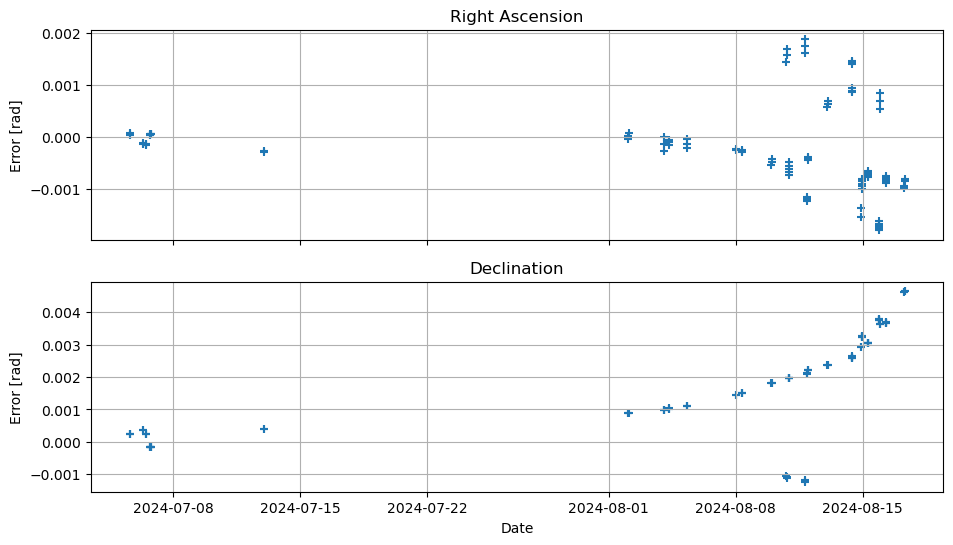

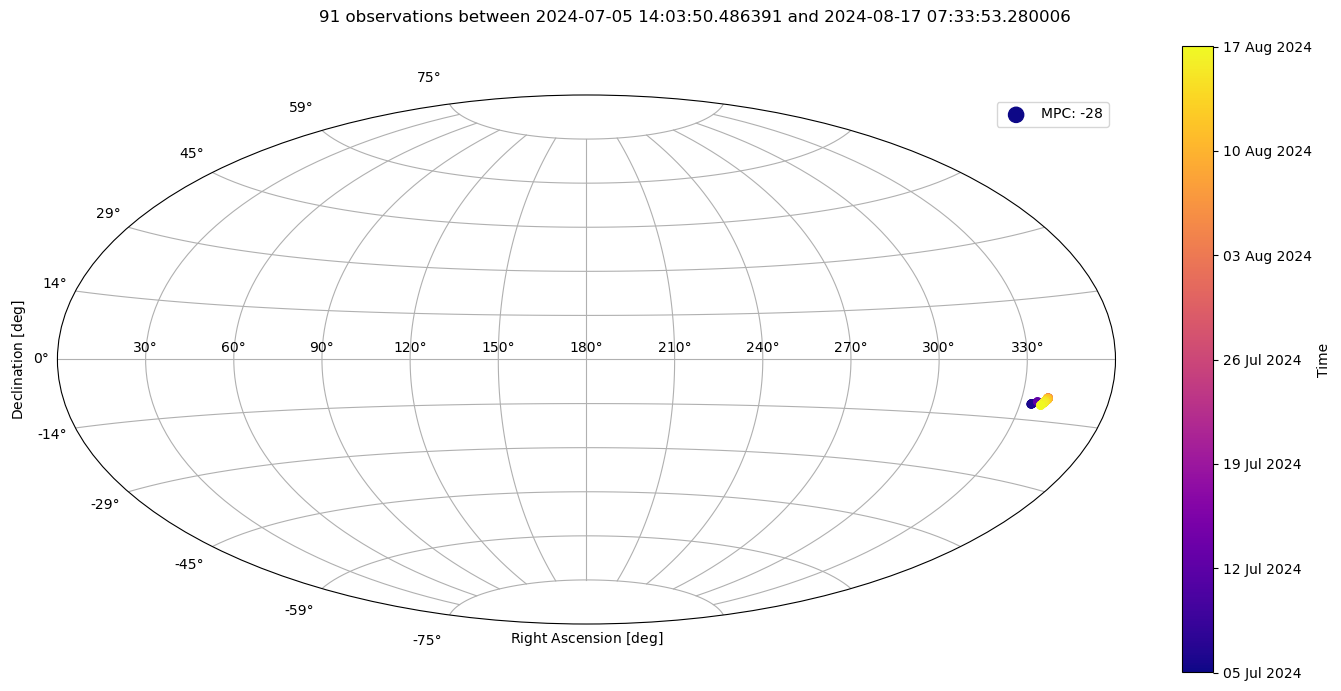

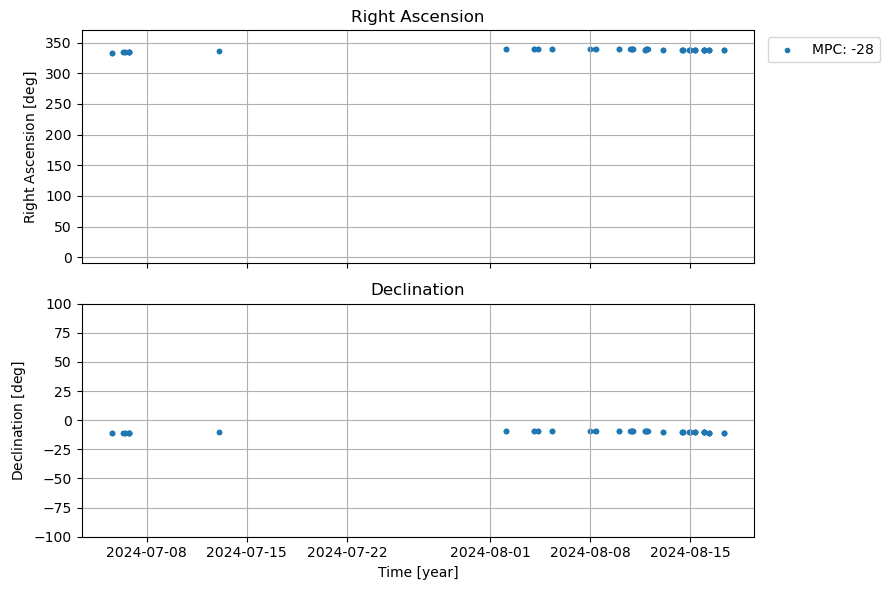

In [261]:
# create plot
fig, (ax_ra, ax_dec) = plt.subplots(2, 1, figsize=(11, 6), sharex=True)

#print(f'RA residuals:\n {jpl_RA - batch_RA}')
#print(f'DEC residuals:\n + {jpl_DEC-batch_DEC}')

ax_ra.scatter(batch_times_utc, (jpl_RA - batch_RA), marker="+")
ax_dec.scatter(batch_times_utc, (jpl_DEC - batch_DEC), marker="+")

ax_ra.set_ylabel("Error [rad]")
ax_dec.set_ylabel("Error [rad]")
ax_dec.set_xlabel("Date")

ax_ra.grid()
ax_dec.grid()

ax_ra.set_title("Right Ascension")
ax_dec.set_title("Declination")

plt.show()

### Plotting observations
"""
The `.plot_observations_sky()` method can be used to view a projection of the observations. Similarly, `.plot_observations_temporal()` shows the declination and right ascension of a batch's bodies over time.
"""

#print(f'batch_RA in radians from table.query: \n\n{batch_RA}') 
#print(f'batch_RA in degrees: \n\n{np.degrees(batch_RA)}') 
#print(f'batch_DEC in radians from table.query: \n\n{batch_DEC}') 
#print(f'batch_DEC in degrees: \n\n{np.degrees(batch_DEC)}') 

# Try some of the other projections: 'hammer', 'mollweide' and 'lambert'
fig = batch1.plot_observations_sky(projection = 'aitoff')
plt.show()

fig = batch1.plot_observations_temporal()
plt.show()

In [267]:
from tudatpy.util import result2array

# Retrieve the first and final observation epochs and add the buffer
epoch_start_nobuffer = batch1.epoch_start
epoch_end_nobuffer = batch1.epoch_end

print(f'Epoch Start (no buffer): {epoch_start_nobuffer}')
print(f'Epoch End (no buffer): {epoch_end_nobuffer}')

time_buffer = 86400/2

#number of iterations for our estimation
number_of_pod_iterations = 6

# timestep of 300s for our estimation
timestep_global = 300

epoch_start_buffer = epoch_start_nobuffer - time_buffer 
epoch_end_buffer = epoch_end_nobuffer + time_buffer 

print(f'Epoch Start (with buffer): {epoch_start_buffer}')
print(f'Epoch End (with buffer): {epoch_end_buffer}')

Epoch Start (no buffer): 773460299.6704056
Epoch End (no buffer): 777152102.462934
Epoch Start (with buffer): 773417099.6704056
Epoch End (with buffer): 777195302.462934


In [276]:
# Define accelerations
accelerations = {
    "Sun": [
        propagation_setup.acceleration.point_mass_gravity(),
        propagation_setup.acceleration.relativistic_correction(use_schwarzschild=True),
    ],
    "Mercury": [propagation_setup.acceleration.point_mass_gravity()],
    "Venus": [propagation_setup.acceleration.point_mass_gravity()],
    "Earth": [propagation_setup.acceleration.point_mass_gravity()],
    "Moon": [propagation_setup.acceleration.point_mass_gravity()],
    "Mars": [propagation_setup.acceleration.point_mass_gravity()],
    "Jupiter": [propagation_setup.acceleration.point_mass_gravity()],
    "Saturn": [propagation_setup.acceleration.point_mass_gravity()],
    "Uranus": [propagation_setup.acceleration.point_mass_gravity()],
    "Neptune": [propagation_setup.acceleration.point_mass_gravity()],
}

# Set up the accelerations settings for each body, in this case only JUICE
acceleration_settings = {}
for body in batch1.MPC_objects:
    acceleration_settings[str(body)] = accelerations

acceleration_settings
# create the acceleration models.
acceleration_models = propagation_setup.create_acceleration_models(
    bodies, acceleration_settings, bodies_to_propagate, central_bodies
)


#benchmark state for later comparison retrieved from SPICE
initial_states = spice.get_body_cartesian_state_at_epoch(
    'JUICE',
    global_frame_origin,
    global_frame_orientation,
    "NONE",
    epoch_start_buffer,
)
print(global_frame_origin)
print(initial_states)

SSB
[ 8.20010602e+10 -1.55480223e+11 -6.66533673e+10  1.83467724e+04
  1.34968258e+04  5.73767736e+03]


In [277]:
target_spkid = '-28'

spice_state_list = []
epochs_spice = np.arange(epoch_start_buffer, epoch_end_buffer, 100)

for epoch in epochs_spice:
    spice_state = spice.get_body_cartesian_state_at_epoch(
        'JUICE',
        global_frame_origin,
        global_frame_orientation,
        "NONE",
        epoch,
    )
    spice_state_list.append(list(spice_state))

# Add random offset for initial guess
np.random.seed = 1

initial_position_offset = 1e5*1000
initial_velocity_offset = 100

initial_guess = initial_states.copy()
initial_guess[0:3] += (2 * np.random.rand(3) - 1) * initial_position_offset
initial_guess[3:6] += (2 * np.random.rand(3) - 1) * initial_velocity_offset

print("Error between the real initial state and our initial guess:")
print(initial_guess - initial_states)

Error between the real initial state and our initial guess:
[-6.09119327e+07  5.85630848e+07  2.91879270e+07 -9.96462167e+01
  8.45088748e+01 -4.01037491e+01]


In [278]:
# Create numerical integrator settings
integrator_settings = propagation_setup.integrator.runge_kutta_variable_step_size(
    epoch_start_buffer,
    timestep_global,
    propagation_setup.integrator.rkf_78,
    timestep_global,
    timestep_global,
    1.0,
    1.0,
)

x_spice = [state[0] for state in spice_state_list]
y_spice = [state[1] for state in spice_state_list]
z_spice = [state[2] for state in spice_state_list]

# Terminate at the time of oldest observation
termination_condition = propagation_setup.propagator.time_termination(epoch_end_buffer)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies=central_bodies,
    acceleration_models=acceleration_models,
    bodies_to_integrate=bodies_to_propagate,
    initial_states=initial_guess,
    initial_time=epoch_start_buffer,
    integrator_settings=integrator_settings,
    termination_settings=termination_condition,
)

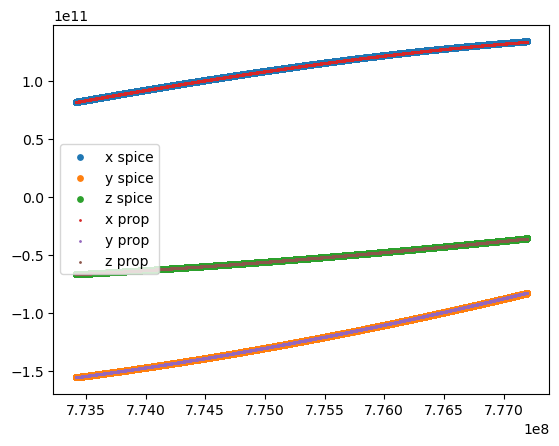

Error between the real spice final state and our final state:
[-4.79406593e+08  4.40709019e+08 -7.94533734e+07 -1.43015098e+02
  1.22983157e+02 -9.80988871e+00]


In [279]:
# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.create_dynamics_simulator(
    bodies, propagator_settings
)

# Extract the resulting state history and convert it to an ndarray
states = dynamics_simulator.propagation_results.state_history
states_array = result2array(states)

time_prop = [state[0] for state in states_array]
x_prop = [state[1] for state in states_array]
y_prop = [state[2] for state in states_array]
z_prop = [state[3] for state in states_array]


plt.scatter(epochs_spice, x_spice, s = 15, label = 'x spice')
plt.scatter(epochs_spice, y_spice, s = 15, label = 'y spice')
plt.scatter(epochs_spice, z_spice, s = 15, label = 'z spice')
plt.scatter(time_prop, x_prop, s = 1, label = 'x prop')
plt.scatter(time_prop, y_prop, s = 1, label = 'y prop')
plt.scatter(time_prop, z_prop, s = 1, label = 'z prop')


plt.legend()
plt.show()

states_array[:]
print("Error between the real spice final state and our final state:")
print(states_array[-1][1:] - spice_state_list[-1][:])

In [280]:
# Setup parameters settings to propagate the state transition matrix
parameter_settings = estimation_setup.parameter.initial_states(
    propagator_settings, bodies
)

# Create the parameters that will be estimated
parameters_to_estimate = estimation_setup.create_parameter_set(
    parameter_settings, bodies, propagator_settings
)

In [281]:
# Set up the estimator
estimator = numerical_simulation.Estimator(
    bodies=bodies,
    estimated_parameters=parameters_to_estimate,
    observation_settings=observation_settings_list,
    propagator_settings=propagator_settings,
    integrate_on_creation=True,
)

# provide the observation collection as input, and limit number of iterations for estimation.
pod_input = estimation.EstimationInput(
    observations_and_times=observation_collection,
    convergence_checker=estimation.estimation_convergence_checker(
        maximum_iterations=number_of_pod_iterations,
    ),
)

# Set methodological options
pod_input.define_estimation_settings(reintegrate_variational_equations=True)
# Perform the estimation

pod_output = estimator.perform_estimation(pod_input)

Calculating residuals and partials 182
Current residual: 6.18019
Parameter update 4.39518e+12 -1.38043e+12 -3.42488e+11      -840086       514225       169818
Calculating residuals and partials 182
Current residual: 4.4195
Parameter update-2.18219e+16  6.86878e+15   1.7325e+15  4.12522e+09 -2.53212e+09 -8.42085e+08
Calculating residuals and partials 182


Warning, detected jump in observation residual of size 5.98171 for observable type 1
Warning, detected jump in observation residual of size 5.98163 for observable type 1
Warning, detected jump in observation residual of size 5.98165 for observable type 1
Warning, detected jump in observation residual of size 5.98148 for observable type 1
Warning, detected jump in observation residual of size 5.98153 for observable type 1
Warning, detected jump in observation residual of size 5.97971 for observable type 1
Warning, detected jump in observation residual of size 5.98025 for observable type 1
Warning, detected jump in observation residual of size 5.98016 for observable type 1
Warning, detected jump in observation residual of size 5.98018 for observable type 1
Warning, detected jump in observation residual of size 5.9801 for observable type 1
Warning, detected jump in observation residual of size 5.98012 for observable type 1
Warning, detected jump in observation residual of size 5.94308 for

RuntimeError: Error in interpolator, requesting data point outside of boundaries, requested data at 743746740.43775392 but limit values are 773417099.67040563 and 777195599.67040563